# Peak Detection

Feature detection, also referred to as peak detection, is the process by which local maxima that fulfill certain criteria (such as sufficient signal-to-noise ratio) are located in the signal acquired by a given analytical instrument. 
This process results in “features” associated with the analysis of molecular analytes from the sample under study or from chemical, instrument, or random noise.
Typically, feature detection involves a mass dimension (*m/z*) as well as one or more separation dimensions (e.g. drift and/or retention time), the latter offering distinction among isobaric/isotopic features.

## Persistent Homology

We have recently implemented a peak detection method that leverages persistent homology. Advantages are that it runs faster, uses much less memory, has a measure of signal-to-noise (persistence) built into the method, does not depend on any user-defined parameters, and does not require partitioning of the data to keep the processing tractable. 
We recommend use of this method, though we will continue to make the convolution-based approach available.

In [1]:
import deimos
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%time
# Load data, excluding scanid column
ms1 = deimos.load('example_data.h5', key='ms1', columns=['mz', 'drift_time', 'retention_time', 'intensity'])

CPU times: user 3.35 s, sys: 3.86 s, total: 7.21 s
Wall time: 7.65 s


We will next build arrays containing unique, sorted values (factors) for each dimension of the input data.
This consideration ensures data connectivity in downstream activities (smoothing, peak detection) is not affected by, for example, thresholding.
If an index is built from thresholded data directly, there can be scenarios in which otherwise disconnected data points become connected due to data loss.
Factors can be used to build the index at any point.

In [3]:
%%time
# Build factors from raw data
factors = deimos.build_factors(ms1, dims='detect')

CPU times: user 8.76 s, sys: 2.73 s, total: 11.5 s
Wall time: 11.6 s


For computational efficiency reasons, we next threshold the data before applying downstream operations.

In [4]:
%%time
# Nominal threshold
ms1 = deimos.threshold(ms1, threshold=500)

CPU times: user 568 ms, sys: 641 ms, total: 1.21 s
Wall time: 1.23 s


An index may now be built for the thresholded data for use in the following smoothing and peak detection operations.

In [5]:
%%time
# Build index
index = deimos.build_index(ms1, factors)

CPU times: user 56.3 ms, sys: 4.14 ms, total: 60.5 ms
Wall time: 60 ms


Before peak detection, it is good practice to smooth the data.
The following smoothing parameters were determined by analysis of TuneMix and internal standards to minimize *m/z* error.
Generally, keeping the smooth radius small and increasing number of iterations is preferable to a larger smoothing radius, albeit at greater computational expense.
Notice we pass the index constructed for the thresholded data here.

In [6]:
%%time
# Smooth data
ms1 = deimos.filters.smooth(ms1, index=index, dims=['mz', 'drift_time', 'retention_time'],
                            radius=[0, 1, 0], iterations=7)

CPU times: user 5.09 s, sys: 292 ms, total: 5.38 s
Wall time: 5.43 s


Finally, the peak detection operation.
Note that by supplying a radius per dimension, an intensity-weighted per-dimension coordinate will be returned for each feature.
These steps were combined in order to apply intensity weighting only to detected peaks, as opposed to all data points, improving computational efficiency.
Parameters here are dependent on the resolution of your data.
Zero indicates no weighting will be applied in that dimension.
Notice we again pass the index constructed for the thresholded data here.

In [7]:
%%time
# Perform peak detection
ms1_peaks = deimos.peakpick.persistent_homology(ms1, index=index,
                                                dims=['mz', 'drift_time', 'retention_time'],
                                                radius=[2, 10, 0])

# Sort by persistence
ms1_peaks = ms1_peaks.sort_values(by='persistence', ascending=False).reset_index(drop=True)
ms1_peaks

CPU times: user 5.18 s, sys: 547 ms, total: 5.73 s
Wall time: 5.72 s


,mz,drift_time,retention_time,intensity,persistence,mz_weighted,drift_time_weighted,retention_time_weighted
0,496.335480,28.378529,1.926033,47870.839844,47370.008285,496.337463,28.336977,1.926034
1,192.091949,16.594225,9.035784,37407.832031,36907.687972,192.094498,16.632273,9.035781
2,204.121979,16.954967,8.494817,36476.816406,35976.445785,204.123215,17.011349,8.494816
3,118.085197,13.467776,8.224500,36248.109375,35747.613753,118.086433,13.758590,8.224499
4,144.099182,14.670256,7.181000,34877.378906,34377.035628,144.101120,14.669243,7.181000
...,...,...,...,...,...,...,...,...
12864,582.417297,30.783487,2.312300,502.000000,1.027358,582.417297,30.996725,2.312300
12865,611.250916,28.739271,1.037067,1451.595947,1.018677,611.247253,28.496101,1.037066
12866,758.666321,35.593407,2.505433,731.699463,1.014221,758.661865,35.406212,2.505433
12867,118.085197,13.588024,10.233833,1418.360596,1.007446,118.085907,13.693040,10.233833


The `persistence` column indicates the "height" of a given feature relative to the filtration. 
Higher values indicate greater prominence with respect to the surrounding signal.

## Maximum Filtration

The version of DEIMoS published in Analytical Chemistry implements an N-dimensional maximum filter from [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html) that convolves the instrument signal with a structuring element, also known as a kernel, and compares the result against the input array to identify local maxima as candidate features or peaks.
To demonstrate, we will operate on a subset of 2D data to minimize memory usage and computation time.

In [8]:
# Load data, excluding scanid column
ms1 = deimos.load('example_data.h5', key='ms1', columns=['mz', 'drift_time', 'retention_time', 'intensity'])

# Sum over retention time
ms1_2d = deimos.collapse(ms1, keep=['mz', 'drift_time'])

In [9]:
%%time
# Perform peak detection
ms1_peaks = deimos.peakpick.local_maxima(ms1_2d, dims=['mz', 'drift_time'], bins=[37, 9])

CPU times: user 17.6 s, sys: 3.67 s, total: 21.3 s
Wall time: 22.2 s


### Selecting Kernel Size

Key to this process is the selection of kernel size, which can vary by instrument, dataset, and even compound.
For example, in LC-IMS-MS/MS data, peak width increases with increasing *m/z* and drift time, and also varies in retention time. 
Ideally, the kernel would be the same size as the N-dimensional peak (i.e. wavelets), though computational efficiency considerations for high-dimensional data currently limit the ability to dynamically adjust kernel size.
Thus, the selected kernel size should be representative of likely features of interest.

This process is exploratory, and selections can be further refined pending an initial processing of the data.
To start, we will get a sense of our data by visualizing a high-intensity feature.

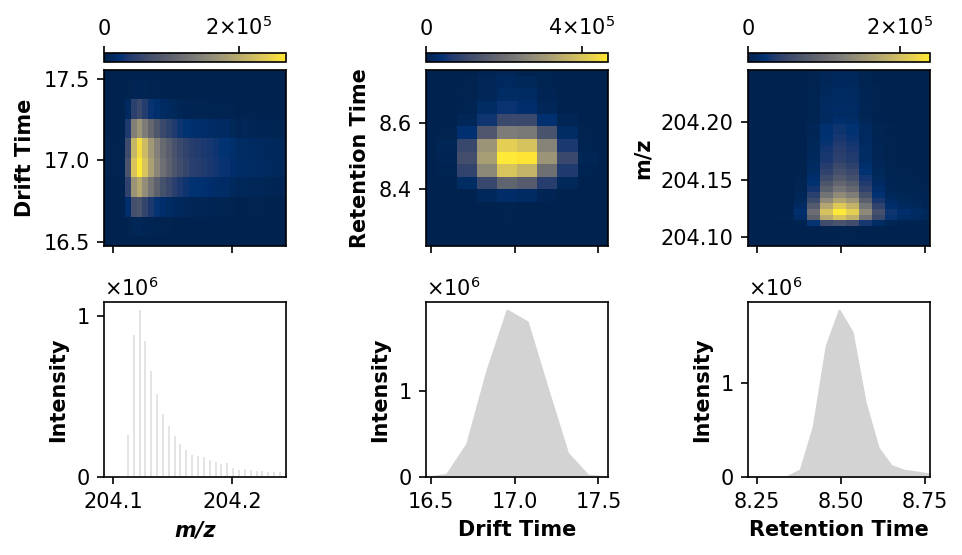

In [10]:
# Subset to lower mass range
ms1_ss = deimos.slice(ms1, by='mz', low=150, high=250)

# Get maximal data point
mz_i, dt_i, rt_i, intensity_i = ms1_ss.loc[ms1_ss['intensity'] == ms1_ss['intensity'].max(), :].round(1).values[0]

# Subset the raw data
feature = deimos.slice(ms1,
                       by=['mz', 'drift_time', 'retention_time'],
                       low=[mz_i - 0.01, dt_i - 0.6, rt_i - 0.3],
                       high=[mz_i + 0.15, dt_i + 0.6, rt_i + 0.3])

# Visualize
deimos.plot.multipanel(feature, dpi=150)
plt.tight_layout()
plt.show()

In [11]:
print('{}:\t\t{}'.format('mz', len(feature['mz'].unique())))
print('{}:\t{}'.format('drift_time', len(feature['drift_time'].unique())))
print('{}:\t{}'.format('retention_time', len(feature['retention_time'].unique())))

mz:		32
drift_time:	10
retention_time:	14


The number of sampled data points in each dimension informs selection of suitable peak detection parameters, in this case 32 values in *m/z*, 10 values in drift time, and 14 values in retention time. 
For the kernel to be centered on each "voxel", however, selections must be odd. 
Due to the multidimensional nature of the data, kernel size need not be exact: two features need only be separated in one dimension, not all dimensions simultaneously.

### Partitioning

This dataset is comprised of almost 200,000 unique *m/z* values, 416 unique drift times, and 568 unique retention times.
In order to process the data by N-dimensional filter convolution, the data frame-based coordinate format must be converted into a dense array. 
In this case, a dense array would comprise 4.7E9 cells and, for 32-bit intensities, require approximately 174 GB of memory. 

In [12]:
print('{}:\t\t{}'.format('mz', len(ms1['mz'].unique())))
print('{}:\t{}'.format('drift_time', len(ms1['drift_time'].unique())))
print('{}:\t{}'.format('retention_time', len(ms1['retention_time'].unique())))

mz:		197408
drift_time:	416
retention_time:	568


This is of course not tenable for many workstations, necessitating a partitioning utility by which the input may be split along a given dimension, each partition processed separately. 
Here, we create a `Partitions` object to divide the *m/z* dimension into chunks of 1000 unique values, with a partition overlap of 0.2 Da to ameliorate artifacts arising from artificial partition "edges".
Next, its `map` method is invoked to apply peak detection to each partition.

The `processes` flag may also be specified to spread the computational load over multiple cores.
Memory footprint scales linearly with number of processes.
Note that we will not observe any performance improvement for this 2D example case.

In [13]:
%%time
# Partition the data
partitions = deimos.partition(ms1_2d, split_on='mz', size=10000, overlap=0.5)

# Map peak detection over partitions
ms1_peaks_partitioned = partitions.map(deimos.peakpick.local_maxima,
                                       dims=['mz', 'drift_time'],
                                       bins=[37, 9],
                                       processes=8)

CPU times: user 19.2 s, sys: 11.5 s, total: 30.7 s
Wall time: 36.8 s


With `overlap` selected appropriately, the partitioned result should be identical to the previous result.

In [14]:
all(ms1_peaks_partitioned == ms1_peaks)

True

### Kernel Scaling

Peak width in *m/z* and drift time increase with *m/z*. 
In the example data used here, the sample inverval in *m/z* also increases with increasing *m/z*.
This means that our kernel effectively "grows" as *m/z* increases, as kernel is selected by number of such intervals rather than an *m/z* range.

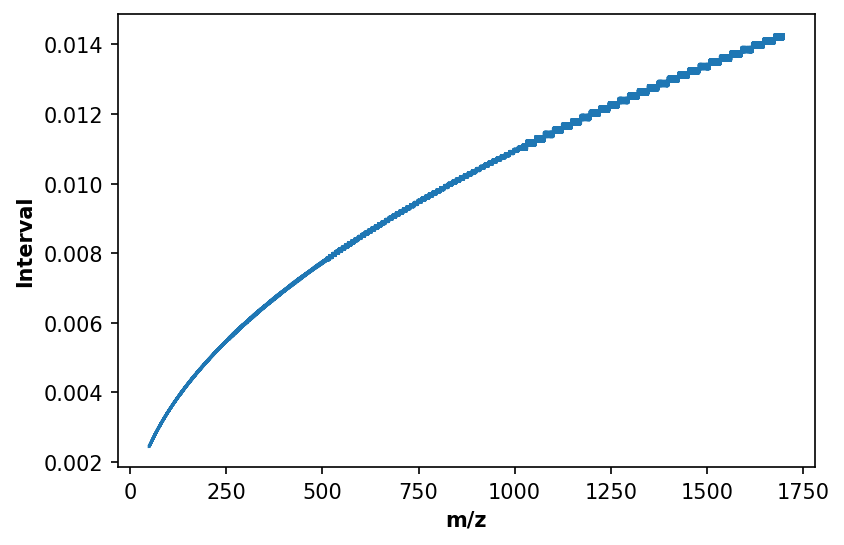

In [15]:
# Unique m/z values
mz_unq = np.unique(ms1_2d['mz'])

# m/z sample intervals
mz_diff = np.diff(mz_unq)

# Visualize
plt.figure(dpi=150)
plt.plot(mz_unq[1:], mz_diff)
plt.xlabel('m/z', fontweight='bold')
plt.ylabel('Interval', fontweight='bold')
plt.show()

However, the drift time sample interval is constant throughout the acquisition. 
To accommodate increasing peak width in drift time, we can scale the kernel in that dimension by the *m/z* per partition, scaled by a reference resolution (i.e. the minimum interval in the above).
Thus, the drift time kernel size of the first partition will be scaled by a factor of 1 (no change), the last by a factor of ~1.4.
This represents an advanced usage scenario and should only be considered with sufficient justification. 
That is, knowledge of sample intervals in each dimension, peak widths as a function of these sample intervals, and whether the relationship(s) scale linearly.

In [16]:
%%time
# Partition the data
partitions = deimos.partition(ms1_2d, split_on='mz', size=10000, overlap=0.5)

# Map peak detection over partitions
ms1_peaks_partitioned = partitions.map(deimos.peakpick.local_maxima,
                                       dims=['mz', 'drift_time'],
                                       bins=[37, 9],
                                       scale_by='mz',
                                       ref_res=mz_diff.min(),
                                       scale=['drift_time'],
                                       processes=8)

CPU times: user 17.3 s, sys: 8.31 s, total: 25.6 s
Wall time: 30.1 s


Note that, though we have ignored retention time, its sample interval in these data is also constant.
However, there is no discernable relationship with *m/z*, thus barring use of this scaling functionality.
In such cases, simply determining an average, representative kernel size is typically sufficient.